# Scattering Cross Section of a Finite Dielectric Cylinder

As an alternative to the "ring" sources of the previous examples, it is also possible to launch planewaves in cylindrical coordinates. This is demonstrated in this example which involves computing the scattering cross section of a finite-height dielectric cylinder. The results for the 2d simulation involving the cylindrical $(r,z)$ cell are validated by comparing to the same simulation in 3d Cartesian coordinates which tends to be much slower and less accurate at the same grid resolution.

The calculation of the scattering cross section is described in [Tutorial/Basics/Mie Scattering of a Lossless Dielectric Sphere](https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics/#mie-scattering-of-a-lossless-dielectric-sphere) which is modified for this example. A linearly-polarized planewave is normally incident on a $z$-oriented cylinder which is enclosed by a DFT flux box. Expressed in cylindrical coordinates, an $x$-polarized planewave propagating in the $z$ direction is the sum of two circularly-polarized planewaves of opposite chirality:

<center>
$$ \hat{E}_x = \frac{1}{2} \left[e^{i\phi}(\hat{E}_\rho + i\hat{E}_\phi) + e^{-i\phi}(\hat{E}_\rho - i\hat{E}_\phi)\right] $$
</center>

In practice, this involves performing two separate simulations for $m=\pm 1$. The scattered power from each simulation is then simply summed since the cross term in the total Poynting flux cancels for the different $m$ values when integrated over the $\phi$ direction. However, only one of the two simulations is necessary: the scattered power is the same for $m=\pm 1$ due to the mirror symmetry of the structure. (Note that a linearly-polarized planewave is *not* $m=0$, which corresponds to a field pattern that is *invariant* under rotations similar to [TE<sub>01</sub>/TM<sub>01</sub> modes](https://en.wikipedia.org/wiki/Transverse_mode). A linear polarization is the superposition of left and right circularly-polarized waves ($m=\pm 1$) and is *not* rotationally invariant; it flips sign if it is rotated by 180°.)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000299931 s
Working in Cylindrical dimensions.
Computational cell is 4 x 0 x 8.88 with resolution 25
time for set_epsilon = 0.052002 s
-----------
Meep: using complex fields.


FloatProgress(value=0.0, description='0% done ', max=15.49778699874878)

run 0 finished at t = 15.5 (775 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000163078 s
Working in Cylindrical dimensions.
Computational cell is 4 x 0 x 8.88 with resolution 25
     block, center = (0.35,0,0)
          size (0.7,0,2.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4,4,4)
time for set_epsilon = 0.053905 s
-----------
Meep: using complex fields.


FloatProgress(value=0.0, description='0% done ', max=105.49778699874878)

Meep progress: 35.94/105.49778699874878 = 34.1% done in 4.0s, 7.7s to go
on time step 1803 (time=36.06), 0.00221964 s/step
Meep progress: 72.2/105.49778699874878 = 68.4% done in 8.0s, 3.7s to go
on time step 3616 (time=72.32), 0.00220671 s/step
run 0 finished at t = 105.5 (5275 timesteps)


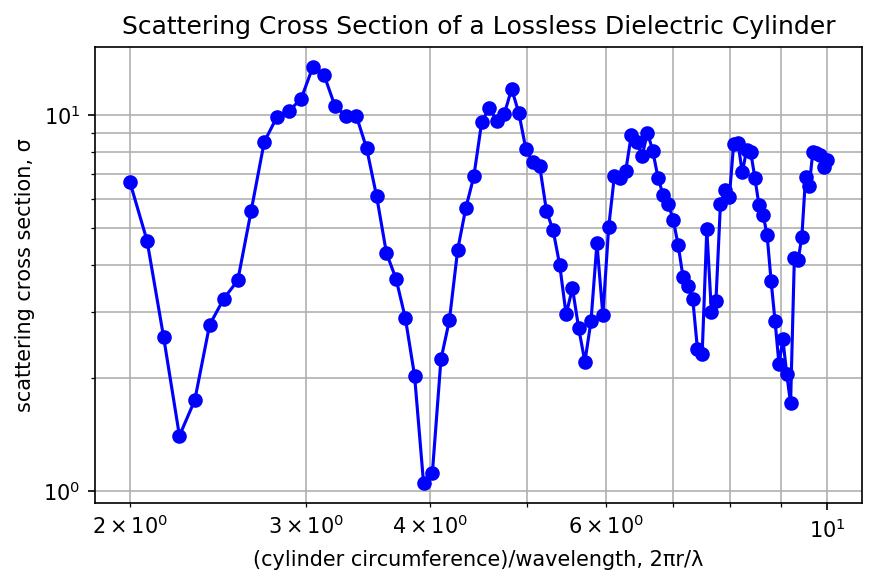

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

r = 0.7  # radius of cylinder
h = 2.3  # height of cylinder

wvl_min = 2 * np.pi * r / 10
wvl_max = 2 * np.pi * r / 2

frq_min = 1 / wvl_max
frq_max = 1 / wvl_min
frq_cen = 0.5 * (frq_min + frq_max)
dfrq = frq_max - frq_min
nfrq = 100

## at least 8 pixels per smallest wavelength, i.e. np.floor(8/wvl_min)
resolution = 25

dpml = 0.5 * wvl_max
dair = 1.0 * wvl_max

pml_layers = [mp.PML(thickness=dpml)]

sr = r + dair + dpml
sz = dpml + dair + h + dair + dpml
cell_size = mp.Vector3(sr, 0, sz)

sources = [
    mp.Source(
        mp.GaussianSource(frq_cen, fwidth=dfrq, is_integrated=True),
        component=mp.Er,
        center=mp.Vector3(0.5 * sr, 0, -0.5 * sz + dpml),
        size=mp.Vector3(sr),
    ),
    mp.Source(
        mp.GaussianSource(frq_cen, fwidth=dfrq, is_integrated=True),
        component=mp.Ep,
        center=mp.Vector3(0.5 * sr, 0, -0.5 * sz + dpml),
        size=mp.Vector3(sr),
        amplitude=-1j,
    ),
]

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    resolution=resolution,
    sources=sources,
    dimensions=mp.CYLINDRICAL,
    m=-1,
)

box_z1 = sim.add_flux(
    frq_cen,
    dfrq,
    nfrq,
    mp.FluxRegion(center=mp.Vector3(0.5 * r, 0, -0.5 * h), size=mp.Vector3(r)),
)
box_z2 = sim.add_flux(
    frq_cen,
    dfrq,
    nfrq,
    mp.FluxRegion(center=mp.Vector3(0.5 * r, 0, +0.5 * h), size=mp.Vector3(r)),
)
box_r = sim.add_flux(
    frq_cen, dfrq, nfrq, mp.FluxRegion(center=mp.Vector3(r), size=mp.Vector3(z=h))
)

sim.run(until_after_sources=10)

freqs = mp.get_flux_freqs(box_z1)
box_z1_data = sim.get_flux_data(box_z1)
box_z2_data = sim.get_flux_data(box_z2)
box_r_data = sim.get_flux_data(box_r)

box_z1_flux0 = mp.get_fluxes(box_z1)

sim.reset_meep()

n_cyl = 2.0
geometry = [
    mp.Block(
        material=mp.Medium(index=n_cyl),
        center=mp.Vector3(0.5 * r),
        size=mp.Vector3(r, 0, h),
    )
]

sim = mp.Simulation(
    cell_size=cell_size,
    geometry=geometry,
    boundary_layers=pml_layers,
    resolution=resolution,
    sources=sources,
    dimensions=mp.CYLINDRICAL,
    m=-1,
)

box_z1 = sim.add_flux(
    frq_cen,
    dfrq,
    nfrq,
    mp.FluxRegion(center=mp.Vector3(0.5 * r, 0, -0.5 * h), size=mp.Vector3(r)),
)
box_z2 = sim.add_flux(
    frq_cen,
    dfrq,
    nfrq,
    mp.FluxRegion(center=mp.Vector3(0.5 * r, 0, +0.5 * h), size=mp.Vector3(r)),
)
box_r = sim.add_flux(
    frq_cen, dfrq, nfrq, mp.FluxRegion(center=mp.Vector3(r), size=mp.Vector3(z=h))
)

sim.load_minus_flux_data(box_z1, box_z1_data)
sim.load_minus_flux_data(box_z2, box_z2_data)
sim.load_minus_flux_data(box_r, box_r_data)

sim.run(until_after_sources=100)

box_z1_flux = mp.get_fluxes(box_z1)
box_z2_flux = mp.get_fluxes(box_z2)
box_r_flux = mp.get_fluxes(box_r)

scatt_flux = np.asarray(box_z1_flux) - np.asarray(box_z2_flux) - np.asarray(box_r_flux)
intensity = np.asarray(box_z1_flux0) / (np.pi * r**2)
scatt_cross_section = np.divide(-scatt_flux, intensity)

plt.figure(dpi=150)
plt.loglog(2 * np.pi * r * np.asarray(freqs), scatt_cross_section, "bo-")
plt.grid(True, which="both", ls="-")
plt.xlabel("(cylinder circumference)/wavelength, 2πr/λ")
plt.ylabel("scattering cross section, σ")
plt.title("Scattering Cross Section of a Lossless Dielectric Cylinder")
plt.tight_layout()
plt.show()

Note that the "closed" DFT flux box is comprised of just three flux objects: two along $z$ and one in the radial $r$ direction. The function `get_fluxes` which computes the integral of the Poynting vector is over the annular volume in cylindrical coordinates. There is no need for additional post-processing of the flux values.

As shown below, the results for the scattering cross section computed using cylindrical coordinates agree well with the 3d Cartesian simulation. However, there is a large discrepancy in performance: for a single Intel Xeon 4.2GHz processor, the runtime of the cylindrical simulation is nearly 90 times shorter than the 3d simulation.

![](https://meep.readthedocs.io/en/latest/images/cylinder_cross_section.png)